# LightGBM
### Modelo LightGBM utilizando apenas as variáveis categóricas da base de dados

In [60]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

## Dataframes

In [61]:
df_public = pd.read_csv('dados/public.csv')
df_metar = pd.read_csv('dados/metar.csv', low_memory=False)

## data_ref

In [62]:
df_public['data_ref'] = df_public['hora_ref'].apply(lambda x: x[:7])

## Merge

In [63]:
df_public_metar = df_public.merge(df_metar, how='left', left_on=['metar', 'data_ref'], right_on=['meta', 'date'])

## Datasets de Treino e Teste

In [64]:
df_numeric = df_public_metar.select_dtypes(include=np.number)

In [65]:
# Dataframe para envio na competição
df_test_final = df_numeric[df_numeric.espera.isnull()].drop('espera',axis=1)

# Dataframes de treino e teste
df_train_inicial = df_numeric[~df_numeric.espera.isnull()]
X_train_inicial = df_train_inicial.drop('espera', axis=1)
y_train_inicial = df_train_inicial['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_inicial, y_train_inicial, test_size=0.20, random_state=42, stratify=y_train_inicial)

In [66]:
train_data_lgb = lgb.Dataset(X_train, label=y_train)
validation_data_lgb = lgb.Dataset(X_test, label=y_test)

## Parâmetros

In [67]:
param = {'num_leaves': 100, 'objective': 'binary', 'metric': 'f1'}

## Treino

In [68]:
num_round = 10
bst = lgb.train(param, train_data_lgb, num_round, valid_sets=[validation_data_lgb])

[LightGBM] [Info] Number of positive: 2949, number of negative: 166394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 169343, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017414 -> initscore=-4.032892
[LightGBM] [Info] Start training from score -4.032892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [69]:
y_pred = bst.predict(X_test)

In [70]:
print(f1_score(y_test.to_list(), np.int8(y_pred > 0.95).tolist(), average='binary'))

0.0


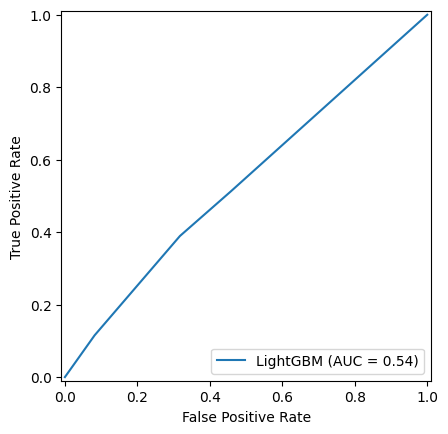

In [71]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='LightGBM')
display.plot()
plt.show()

## Teste e Submissão

In [79]:
sub = df_public_metar[df_public_metar.espera.isnull()].drop('espera',axis=1).flightid

In [80]:
sub = pd.DataFrame(sub)

In [81]:
y_pred = bst.predict(df_test_final)

In [82]:
sub['espera'] = np.int8(y_pred > 0.02)

In [91]:
(y_pred > 0.02).any()

True

In [84]:
sub.to_csv('submission.csv',index=False)